In [2]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import hist, processor
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from pprint import pprint
import numba

In [3]:
def show(a, ievt=0):
    pprint(a[ievt].tolist())

In [157]:
filename = "/pnfs/psi.ch/cms/trivcat/store/user/mmarcheg/RunIIFall17NanoAODv7/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/587E2464-42CA-3A45-BD49-D23E49F658E6.root"
#events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema).events()
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=150000).events()

dataset = "ttHTobb"

In [5]:
ievt = 0

In [6]:
%load_ext snakeviz

In [158]:
%%time

isOutgoing = events.LHEPart.status == 1
isB = abs(events.LHEPart.pdgId) == 5
bquarks = events.LHEPart[isB & isOutgoing]

# Select b-quarks at Gen level, coming from H->bb decay
if dataset == 'ttHTobb':
    isHiggs = events.GenPart.pdgId == 25
    isHard = events.GenPart.hasFlags(['fromHardProcess'])
    hasTwoChildren = ak.num(events.GenPart.childrenIdxG, axis=2) == 2
    higgs = events.GenPart[isHiggs & isHard & hasTwoChildren]
    bquarks = ak.concatenate( (bquarks, ak.flatten(higgs.children, axis=2)), axis=1 )
    # Sort b-quarks by pt
    bquarks = ak.with_name(bquarks[ak.argsort(bquarks.pt, ascending=False)], name='PtEtaPhiMCandidate')


CPU times: user 7.36 s, sys: 4.97 s, total: 12.3 s
Wall time: 12.5 s


In [159]:
%%time
# Compute deltaR(b, jet) and save the nearest jet (deltaR matching)
dr_min = 1
deltaR = ak.flatten(bquarks.metric_table(events.Jet), axis=2)
# keeping only the pairs with a deltaR min
maskDR = deltaR < dr_min
deltaRcut = deltaR[maskDR] #--> the mask works since we are applying it also to the argcartesian
idx_pairs_sorted = ak.argsort(deltaRcut, axis=1)
pairs = ak.argcartesian([bquarks, events.Jet])[maskDR]
pairs_sorted = pairs[idx_pairs_sorted]
idx_quark, idx_jets = ak.unzip(pairs_sorted)

CPU times: user 4.87 s, sys: 1.66 s, total: 6.53 s
Wall time: 6.53 s


In [9]:
show(deltaRcut,1)

[0.057874202728271484, 0.24081091582775116, 0.06480082869529724]


In [10]:
show(pairs,1)

[(0, 0), (1, 1), (2, 5)]


In [11]:
show(idx_pairs_sorted,1)

[0, 2, 1]


In [12]:
pairs_sorted[0:10].tolist()

[[(1, 2), (2, 4), (3, 5), (0, 1)],
 [(0, 0), (2, 5), (1, 1)],
 [(1, 2), (0, 0), (3, 8), (2, 5)],
 [(2, 4), (0, 0), (3, 5), (1, 2)],
 [(0, 1), (1, 3), (2, 1)],
 [(2, 2), (1, 0), (3, 5), (0, 2), (0, 1), (2, 3)],
 [(1, 1), (0, 2), (2, 4), (3, 5)],
 [(1, 2), (0, 1), (2, 3), (3, 6)],
 [(0, 2), (2, 5), (1, 6)],
 [(2, 1), (0, 0), (3, 2), (1, 5)]]

In [13]:
def get_valid_pairs_masks(idx_bquarks, idx_Jet):
    hasMatch = ak.zeros_like(idx_Jet, dtype=bool)
    Npairmax = ak.max(ak.num(idx_bquarks))
    # Loop over the (parton, jet) pairs
    for idx_pair in range(Npairmax):
        idx_bquark = ak.pad_none(idx_bquarks, Npairmax)[:,idx_pair]
        idx_match_candidates = idx_Jet[ak.fill_none( (idx_bquarks == idx_bquark) & ~hasMatch, False)]
        idx_pair_candidates  = ak.local_index(idx_Jet)[ak.fill_none( (idx_bquarks == idx_bquark) & ~hasMatch, False)]
        #print(idx_bquark[ievt], idx_match_candidates[ievt])
        #print(idx_bquark[ievt], idx_pair_candidates[ievt])
        if idx_pair == 0:
            idx_matchedJet    = ak.unflatten( ak.firsts(idx_match_candidates), 1 )
            idx_matchedParton = ak.unflatten( idx_bquark, 1 )
            idx_matchedPair   = ak.unflatten( ak.firsts(idx_pair_candidates), 1 )
        else:
            # If the partons are matched in all events or the number of jets is smaller than the number of partons, stop iterating
            if ak.all( ( (ak.count(idx_matchedJet, axis=1) == ak.count(bquarks.pt, axis=1)) | (ak.count(events.Jet.pt, axis=1) < ak.count(bquarks.pt, axis=1) ) ) ): break
            idx_matchedJet    = ak.concatenate( (idx_matchedJet, ak.unflatten( ak.firsts(idx_match_candidates), 1 ) ), axis=1 )
            idx_matchedParton = ak.concatenate( (idx_matchedParton, ak.unflatten( idx_bquark, 1 )), axis=1 )
            idx_matchedPair   = ak.concatenate( (idx_matchedPair, ak.unflatten( ak.firsts(idx_pair_candidates), 1 ) ), axis=1 )
        # The mask `hasMatch` masks to False the 
        hasMatch = hasMatch | ak.fill_none(idx_Jet == ak.fill_none(ak.firsts(idx_match_candidates), -99), False) | ak.fill_none(idx_bquarks == idx_bquark, False)
        #print(idx_pair, hasMatch[ievt].tolist(), end='\n\n')

    idx_matchedParton = idx_matchedParton[~ak.is_none(idx_matchedJet, axis=1)]
    idx_matchedJet = idx_matchedJet[~ak.is_none(idx_matchedJet, axis=1)]
    return idx_matchedParton, idx_matchedJet

In [43]:
def get_valid_pairs_nonumba(idx_quark, idx_jets, builder):
    for ev_q, ev_j in zip(idx_quark, idx_jets):
        builder.begin_list()
        q_done = []
        j_done = []
        for q,j in zip(ev_q, ev_j):
            if q not in q_done and j not in j_done:
                builder.begin_record("pair")
                builder.field("quark").append(q)
                builder.field("jet").append(j)
                builder.end_record()
                q_done.append(q)
                j_done.append(j)
        builder.end_list()
    return builder

In [44]:
@numba.jit
def get_valid_pairs_numba(idx_quark, idx_jets, builder):
    for ev_q, ev_j in zip(idx_quark, idx_jets):
        builder.begin_list()
        q_done = []
        j_done = []
        for q,j in zip(ev_q, ev_j):
            if q not in q_done and j not in j_done:
                builder.begin_record("pair")
                builder.field("quark").append(q)
                builder.field("jet").append(j)
                builder.end_record()
                q_done.append(q)
                j_done.append(j)
        builder.end_list()
    return builder

In [70]:
@numba.jit
def get_valid_pairs_numba_extra(idx_quark, idx_jets, builder, builder2):
    for ev_q, ev_j in zip(idx_quark, idx_jets):
        builder.begin_list()
        builder2.begin_list()
        q_done = []
        j_done = []
        for q,j in zip(ev_q, ev_j):
            if q not in q_done:
                if j not in j_done:
                    builder.begin_record("pair")
                    builder.field("quark").append(q)
                    builder.field("jet").append(j)
                    builder.end_record()
                    q_done.append(q)
                    j_done.append(j)
                else:
                    builder2.begin_record("missed_pair")
                    builder2.field("quark").append(q)
                    builder2.field("jet").append(j)
                    builder2.end_record()
        builder.end_list()
        builder2.end_list()
    return builder, builder2

In [96]:
@numba.jit
def get_valid_pairs_index_numba(idx_quark, idx_jets, builder):
    for ev_q, ev_j in zip(idx_quark, idx_jets):
        builder.begin_list()
        q_done = []
        j_done = []
        for i, (q,j) in enumerate(zip(ev_q, ev_j)):
            if q not in q_done and j not in j_done:
                builder.append(i)
                q_done.append(q)
                j_done.append(j)
        builder.end_list()
    return builder

In [113]:
def get_valid_pairs_index(idx_quark, idx_jets, builder):
    for ev_q, ev_j in zip(idx_quark, idx_jets):
        builder.begin_list()
        q_done = []
        j_done = []
        for i, (q,j) in enumerate(zip(ev_q, ev_j)):
            if q not in q_done and j not in j_done:
                builder.append(i)
                q_done.append(q)
                j_done.append(j)
        builder.end_list()
    return builder

In [118]:
@numba.jit
def get_valid_pairs_index_more_numba(idx_quark, idx_jets, builder, builder2):
    for ev_q, ev_j in zip(idx_quark, idx_jets):
        builder.begin_list()
        builder2.begin_list()
        q_done = []
        j_done = []
        for i, (q,j) in enumerate(zip(ev_q, ev_j)):
            if q not in q_done:
                if j not in j_done:
                    builder.append(i)
                    q_done.append(q)
                    j_done.append(j)
                else: 
                    builder2.append(i)
        builder.end_list()
        builder2.end_list()
    return builder, builder2

In [110]:
%%timeit
results1 = get_valid_pairs_masks(idx_quark, idx_jets)

2.79 s ± 41.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%%timeit
results2 = get_valid_pairs_nonumba(idx_quark, idx_jets, ak.ArrayBuilder())

9.02 s ± 24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
%%timeit
results3 = get_valid_pairs_numba(idx_quark, idx_jets, ak.ArrayBuilder())

137 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [72]:
%%timeit
results4 = get_valid_pairs_numba_extra(idx_quark, idx_jets, ak.ArrayBuilder(),ak.ArrayBuilder())

143 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [120]:
%%timeit
results5 = get_valid_pairs_index_numba(idx_quark, idx_jets, ak.ArrayBuilder())

61.9 ms ± 180 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [121]:
%%timeit
get_valid_pairs_index_more_numba(idx_quark, idx_jets, ak.ArrayBuilder(), ak.ArrayBuilder())

66.5 ms ± 271 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [114]:
%%timeit
get_valid_pairs_index(idx_quark, idx_jets, ak.ArrayBuilder())

10.2 s ± 26.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
qq, jj = results1
for i, (r, q) in enumerate(zip(results2,  results3)):
    for R,R2 in zip(r,q):
        if R.quark !=R2.quark or R.jet != R2.jet:
            print(i , "Mismatch")

In [ ]:
qq, jj = results1
for i, (r, q, j) in enumerate(zip(results2, qq, jj)):
    mismatch = False
    for R,Q,J in zip(r,q,j):
        if R.quark !=Q or R.jet != J:
            mismatch = True
    if mismatch:
        print(f"ev:{i}, Nquark: {len(q)}, Njets: {len(j)}, match simple: {r}, match complex: {q},{j}")
        print(f"\t original sorted pairs: {pairs_sorted[i]}")

### Checking the results

In [144]:
_matchedPairs, _missedPairs = get_valid_pairs_numba_extra(idx_quark, idx_jets, ak.ArrayBuilder(), ak.ArrayBuilder())
matchedPairs = _matchedPairs.snapshot()
missedPairs = _missedPairs.snapshot()

In [145]:
matchedPairs[10].tolist()

[{'quark': 2, 'jet': 2},
 {'quark': 0, 'jet': 1},
 {'quark': 3, 'jet': 6},
 {'quark': 1, 'jet': 0}]

In [160]:
idx_matched = get_valid_pairs_index_numba(idx_quark, idx_jets, ak.ArrayBuilder()).snapshot()
pairs_sorted[idx_matched][10].tolist()

[(2, 2), (0, 1), (3, 6), (1, 0)]

(array([69758., 72147., 44202., 28428., 19993., 14917., 11553.,  9375.,
         7252.,  6114.,  5166.,  4550.,  4015.,  3577.,  3268.,  3003.,
         2807.,  2806.,  2769.,  3014.,  3471.,  3999.,  4475.,  4955.,
         5543.,  6298.,  6746.,  7190.,  7474.,  7905.,  8245.,  8345.,
         8583.,  8784.,  8931.,  9071.,  9037.,  9138.,  9156.,  9163.,
         9114.,  9211.,  9446.,  9669.,  9824.,  9934., 10258., 10375.,
        10441., 10684.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ], dtype=float32),
 <BarContainer object of 50 artists>)

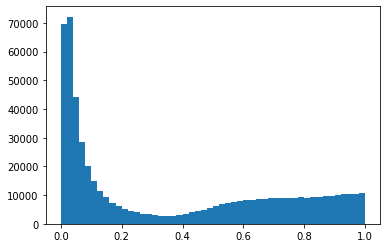

In [169]:
plt.hist(ak.flatten(deltaRcut[idx_matched]), bins=50, range=(0, 1))
# plt.yscale("log")

In [156]:
events.Jet[idx_jets[idx_matched]][10]

<JetArray [Jet, Jet, Jet, Jet] type='4 * ?jet'>

### Check profiling

In [36]:
%%snakeviz 
results1 = get_valid_pairs_masks(idx_quark, idx_jets)

 
*** Profile stats marshalled to file '/tmp/tmpvmveghyp'. 
Embedding SnakeViz in this document...


In [37]:
%%snakeviz 
results3 = get_valid_pairs_numba(idx_quark, idx_jets, ak.ArrayBuilder())

 
*** Profile stats marshalled to file '/tmp/tmpf0yprmct'. 
Embedding SnakeViz in this document...


### Check the performance of first part of the algo

In [28]:
%%timeit
# Compute deltaR(b, jet) and save the nearest jet (deltaR matching)
dr_min = 0.4
deltaR = ak.flatten(bquarks.metric_table(events.Jet), axis=2) 

734 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%%timeit
# keeping only the pairs with a deltaR min
maskDR = deltaR < dr_min
deltaRcut = deltaR[maskDR] #--> the mask works since we are applying it also to the argcartesian

196 ms ± 23.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%%timeit  pass
idx_pairs_sorted = ak.argsort(deltaRcut, axis=1)


21.2 ms ± 4.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
%%timeit pass
pairs = ak.argcartesian([bquarks, events.Jet])[maskDR]

161 ms ± 6.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
%%timeit pass
pairs_sorted = pairs[idx_pairs_sorted]


4.38 ms ± 92.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
%%timeit pass
idx_quark, idx_jets = ak.unzip(pairs_sorted)

170 µs ± 27.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [34]:
%%timeit
# Compute deltaR(b, jet) and save the nearest jet (deltaR matching)
dr_min = 0.4
deltaR = ak.flatten(bquarks.metric_table(events.Jet), axis=2)
# keeping only the pairs with a deltaR min
maskDR = deltaR < dr_min
deltaRcut = deltaR[maskDR] #--> the mask works since we are applying it also to the argcartesian
idx_pairs_sorted = ak.argsort(deltaRcut, axis=1)
pairs = ak.argcartesian([bquarks, events.Jet])[maskDR]
pairs_sorted = pairs[idx_pairs_sorted]
idx_quark, idx_jets = ak.unzip(pairs_sorted)
       

1.01 s ± 94.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
idx_quark

<Array [[1, 2, 3, 0], [0, ... 3, 3], [0, 1, 2]] type='100000 * var * ?int64'>